## <center> **Анализ результатов A/B-тестирования**

## **1. Загрузка и подготовка данных**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Проанализируем эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа решим: какой из вариантов дизайна более предпочтительный.

Фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Переведем формат времени в datetime и убедимся в равности преиодов проведения теста для групп:

In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


Сравним кол-во посещений и покупок, а также общую сумму в разных группах:

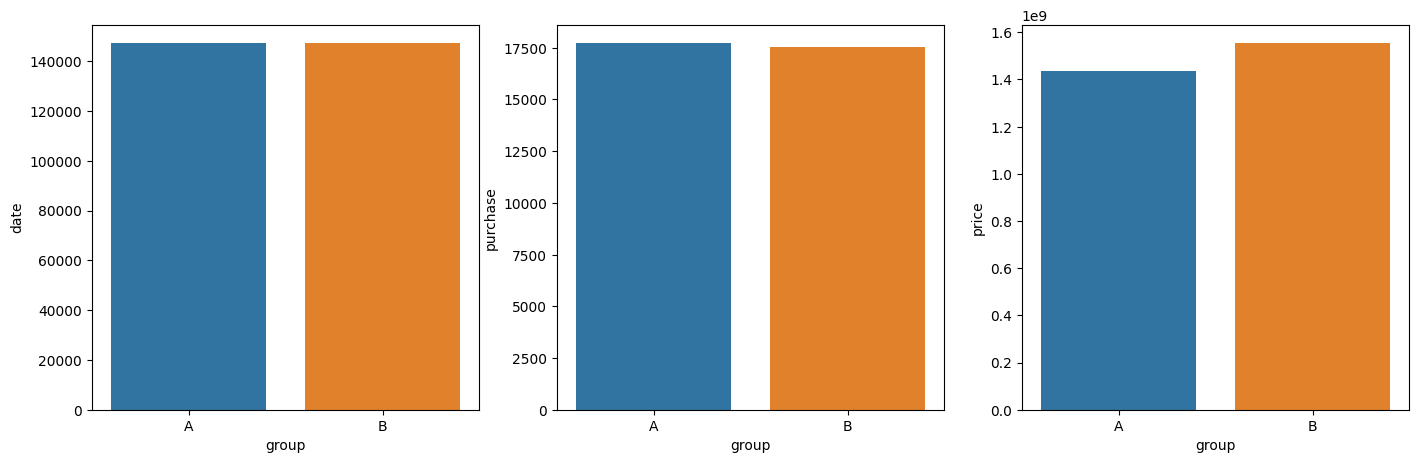

In [5]:
fig, ax = plt.subplots(1,3,figsize=(17, 5))
sns.barplot(data.groupby('group',as_index=False)['date'].count(),x='group',y='date',ax=ax[0]);
sns.barplot(data.groupby('group',as_index=False)['purchase'].sum(),x='group',y='purchase',ax=ax[1]);
sns.barplot(data.groupby('group',as_index=False)['price'].sum(),x='group',y='price',ax=ax[2]);

Посмотрим есть ли клиенты, которые попали в обе группы:

In [6]:
#выделяем группы
data_a = data[data['group'] == 'A']
data_b = data[data['group'] == 'B']

# делаем пересечение множеств для определения общих клиентов
user_intersection = set(data_a['user_id']).intersection(set(data_b['user_id']))

# выводим кол-во общих клиентов
print("Кол-во клиентов в двух группах сразу:", len(user_intersection))

Кол-во клиентов в двух группах сразу: 1895


Так как мы не можем определить какая из версий сайта повлияла на принятие решения для таких клиентов - удалим их:

In [7]:
update_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Для анализа групп создадим новую таблицу. Сгруппируем данные по признаку группы. В каждой группе рассчитаем следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

In [8]:
data = update_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price'})

data

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Кол-во посещений в группах почти одинаковое - можно считать выборку сбалансированной.

Добавим в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе:

In [9]:
data['conversion'] = round((data['count_purchases']/data['count_visits'])*100,2)
data['mean_check'] = round((data['sum_price']/data['count_purchases']))
data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


На данном этапе можно отметить, что конверсия в группе A выше, но в группе B больше средний чек.

Теперь давайте сравним варианты по покупательской способности туров. Построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура:

In [10]:
pivot = update_data.pivot_table(index='group', columns='price', values='purchase', aggfunc='sum')
pivot.head()

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируем полученную таблицу:

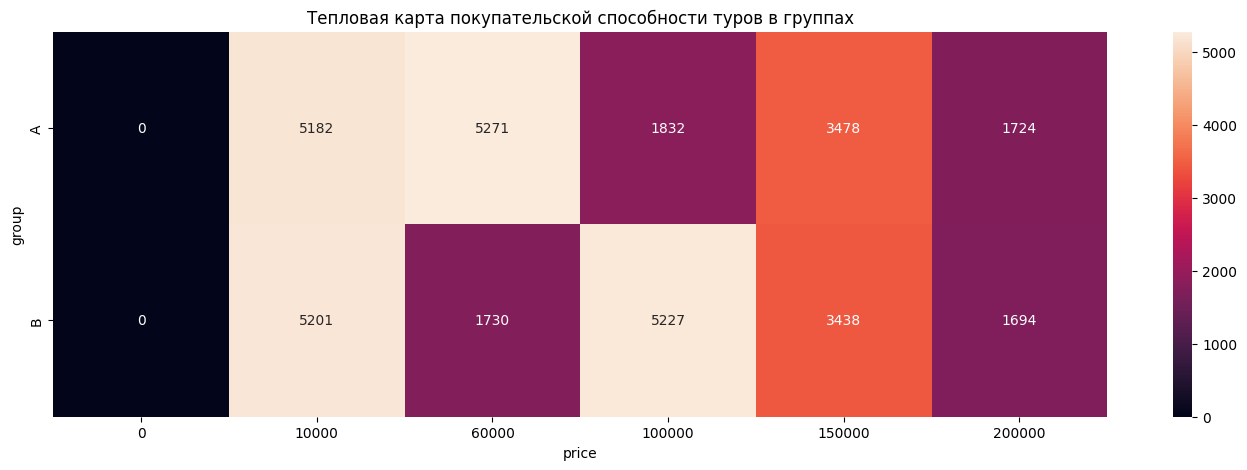

In [16]:
fig = plt.figure(figsize=(17, 5))
ax = sns.heatmap(pivot,annot=True,fmt='.0f')
ax.set_title('Тепловая карта покупательской способности туров в группах');

В группе А кол-во купленных туров за 60000 заметно больше, а в группе В больше купленных туров за 100000, в остальных случаях кол-во купленных туров примерно одинаково. Можно предположить, что именно на эти туры повлиял вариант сайта.

## **2. Оценка кумулятивных метрик**

Далее необходимо рассчитать кумулятивные метрики. Для начала построим таблицу с ежедневными данными результатов проведения A/B-тестирования:

In [19]:
daily_data = update_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits'] * 100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']
daily_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


Добавим в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Также посчитаем кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей:

In [20]:
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()

daily_data['cum_conversion'] = daily_data['cum_count_purchases']/daily_data['cum_count_visits'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_count_purchases']

Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням:

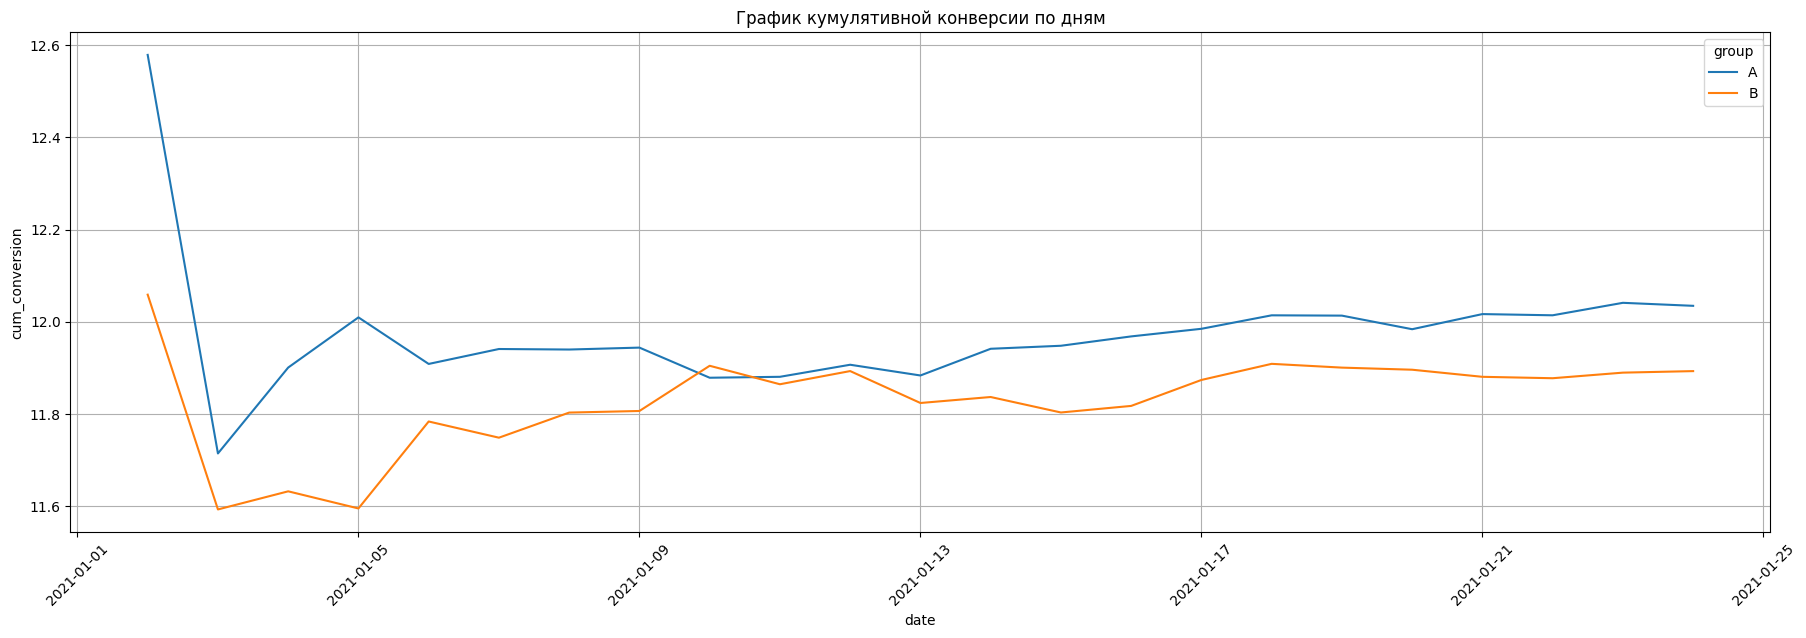

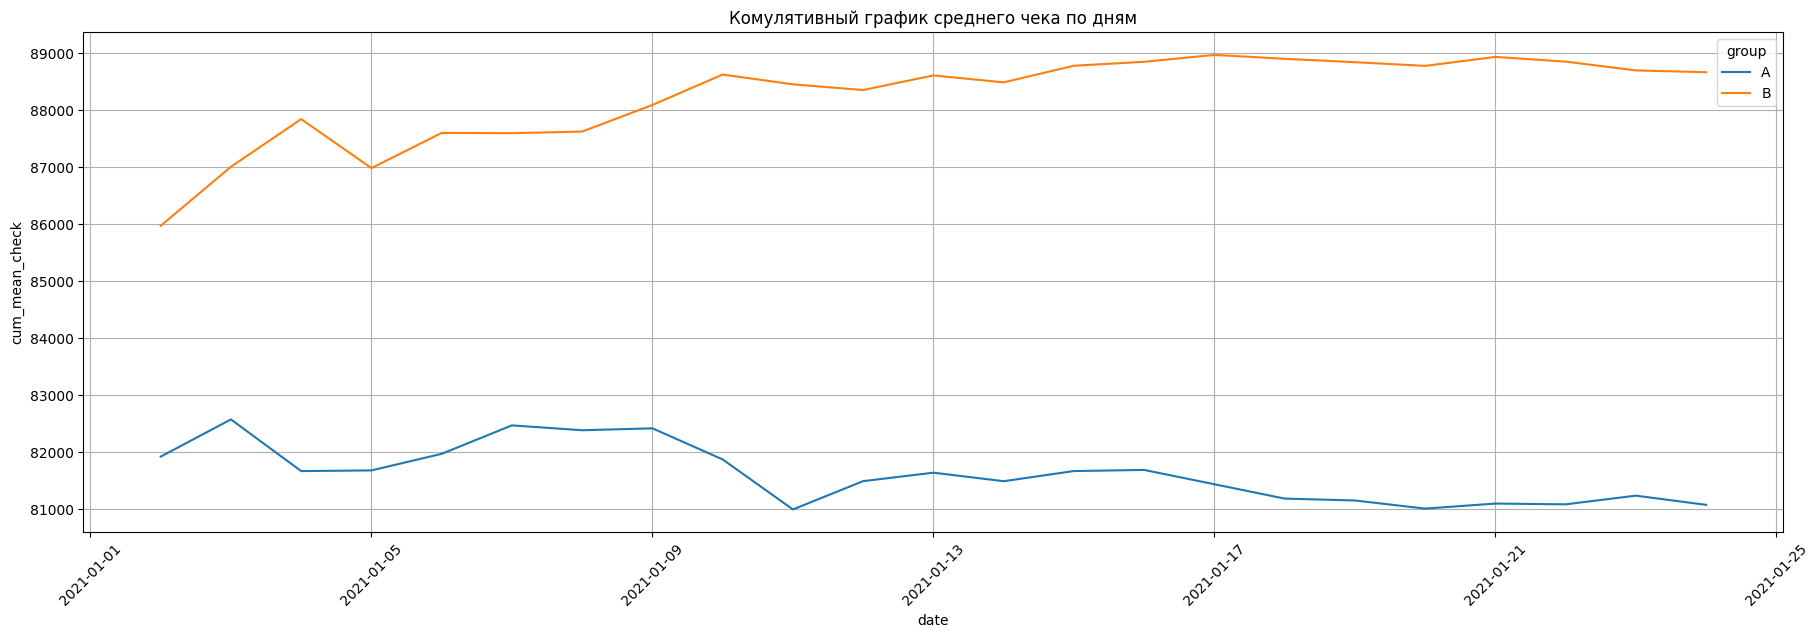

In [22]:
fig = plt.figure(figsize=(17, 5))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

fig2 = plt.figure(figsize=(17, 5))
ax = fig2.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
ax.set_title('Комулятивный график среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

Можно считать A/B завершенным - значения метрик стабилизировались во времени. Комулятивная конверсия по дням стабильно выше в группе А, комулятинвый средний чек по дням стабильно выше в группе В. 

## **3. Статистические тесты (z-тест)**

Перейдем к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Выдвинем следующие гипотезы:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Уровень значимости возьмём $\alpha$=0.5:

In [33]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'

alpha = 0.05

# для оценки p-value используем z-test:
_, p_value = proportions_ztest(
    count=update_data.groupby('group')['purchase'].sum(), 
    nobs=update_data.groupby('group')['purchase'].count(),
    alternative='larger')

print('p-value =',round(p_value, 2))

if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value = 0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Несомтря на то, что визуально конверсия в группе A немного выше - статистической разницы в конверсиях групп А и В нету.

## **4. Довирительные интервалы**
Убедимся в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними:

In [36]:

def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = update_data[update_data['group'] == 'A']
b_data = update_data[update_data['group'] == 'B']

conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)

conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(),
b_data['purchase'].mean() 
)

print("Границы интервала для группы A:", conf_interval_a)
print("Границы интервала для группы B:", conf_interval_b)

Границы интервала для группы A: (11.87, 12.2)
Границы интервала для группы B: (11.73, 12.06)


Интервалы имеют общее пересечение, а значит существует вероятность, что истинное значение конверсии в обеих группах может совпасть. Чтобы однозначно убедится в этом построим доверительный интервал разницы пропорций (конверсий):

In [37]:
def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

diff_inverval = diff_conversion_conf_interval([a_data['user_id'].count(), b_data['user_id'].count()],
[a_data['purchase'].mean(), b_data['purchase'].mean()])

print(diff_inverval)

(-0.38, 0.09)


Интервал разницы охватывает точку 0 - это значит что варианты А и B равнозначны по метрике конверсии. 

## **5. Тест на нормальность и оценка среднего чека**

Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 
Будем использовать тест Шапиро-Уилка:

In [38]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.05

daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

shapiro_a = shapiro(daily_data_a['mean_check'])
shapiro_b = shapiro(daily_data_b['mean_check'])

print(shapiro_a)
print(shapiro_b)

if shapiro_a.pvalue < alpha or shapiro_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

ShapiroResult(statistic=0.9469833970069885, pvalue=0.25307759642601013)
ShapiroResult(statistic=0.9269078373908997, pvalue=0.09378302097320557)
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Сравним варианты дизайна страницы по метрике среднего чека. 

Гипотезы:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Использовать будем t-тест для сравнения средних:

In [42]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'

alpha = 0.05

results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less'
)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу: {}".format(H0))

1.1261794674808954e-12
Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза H1: Ежедневный средний чек в группе А меньше чем в группе B


Проверим доверительным интервалом:

In [43]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)

daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

result_a = mean_check_conf_interval(daily_data_a['count_visits'].count(), daily_data_a['mean_check'].mean(),daily_data_a['mean_check'].std())
result_b = mean_check_conf_interval(daily_data_b['count_visits'].count(), daily_data_b['mean_check'].mean(),daily_data_b['mean_check'].std())

print('Доверительный интервал для среднего чека группы А: {}'.format(result_a)) 
print('Доверительный интервал для среднего чека группы B: {}'.format(result_b ))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Истинное значение среднего чека для группы А лежит в пределах от 79630 до 82308, для группы В от 87626 до 89526. Эти интервалы не пересекаются и иметь общего истиного значения не могут.


## **6. Вывод по результатам A/B-теста**

Статистические тесты показали, что разницы в конверсиях среди двух гупп нету, но зато есть заметная разница в среднем чеке - в варианте В он больше. Исходя из значения метрики по среднему чеку, можно сделать вывод, что вариант В - более эффективный. 